<a href="https://colab.research.google.com/github/ChiefSimp/ME597_Airfoil_Performance_Prediction_Model/blob/main/Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import requests
import io

# Verified correct URL provided by the user
url = "https://raw.githubusercontent.com/ChiefSimp/ME597_Airfoil_Performance_Prediction_Model/refs/heads/main/airfoil_geometry_and_angel_of_stall_data.csv"

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
    csv_content = response.content.decode('utf-8')
    df = pd.read_csv(io.StringIO(csv_content))

    print("Dataset loaded successfully. Displaying the first 5 rows:")
    print(df.head())
except requests.exceptions.RequestException as e:
    print(f"Error downloading or loading dataset: {e}")
    print("Please check the URL or your internet connection.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset loaded successfully. Displaying the first 5 rows:
  airfoil_id            polar_id         Re  max_thickness  \
0    ag03-il   xf-ag03-il-100000   100000.0       0.046692   
1    ag03-il  xf-ag03-il-1000000  1000000.0       0.046692   
2    ag03-il   xf-ag03-il-200000   200000.0       0.046692   
3    ag03-il    xf-ag03-il-50000    50000.0       0.046692   
4    ag03-il   xf-ag03-il-500000   500000.0       0.046692   

   x_at_max_thickness  max_camber  x_at_max_camber  max_cl  alpha_at_max_cl  \
0               0.065    0.051173            0.281  1.0880             9.25   
1               0.065    0.051173            0.281  1.3785            12.25   
2               0.065    0.051173            0.281  1.1490            10.25   
3               0.065    0.051173            0.281  1.0089             8.50   
4               0.065    0.051173            0.281  1.2897            11.25   

   sharpness_rating  radius_rating  
0         92.966907       7.033093  
1         92.966907 

In [26]:
from sklearn.model_selection import train_test_split

# Rename the target column for consistency
df = df.rename(columns={'alpha_at_max_cl': 'angel_of_stall'})

# Separate features (X) and target variable (y)
X = df.drop(columns=['angel_of_stall'])
y = df['angel_of_stall']

# Step 1: Split the data into training (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the temporary set (20%) into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Data preparation complete with 80/10/10 split.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Data preparation complete with 80/10/10 split.
X_train shape: (3973, 10)
y_train shape: (3973,)
X_val shape: (497, 10)
y_val shape: (497,)
X_test shape: (497, 10)
y_test shape: (497,)


In [27]:
import pandas as pd

# Combine X_train and y_train into a single DataFrame
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv('train_data.csv', index=False)

# Combine X_val and y_val into a single DataFrame
val_df = pd.concat([X_val, y_val], axis=1)
val_df.to_csv('validation_data.csv', index=False)

# Combine X_test and y_test into a single DataFrame
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('test_data.csv', index=False)

print("Combined training, validation, and testing data saved to CSV files.")

Combined training, validation, and testing data saved to CSV files.


In [28]:
from catboost import CatBoostRegressor

# Identify categorical features (already defined in previous steps)
# categorical_features = ['airfoil_id', 'polar_id']

# Initialize CatBoostRegressor model with early stopping
# Set verbose=False to suppress training output for cleaner notebook
cat_model = CatBoostRegressor(random_state=42, cat_features=categorical_features, verbose=False)

# Train the model with early stopping using the validation set
print("Training CatBoostRegressor model with early stopping...")
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

print("CatBoostRegressor model trained successfully with early stopping.")

Training CatBoostRegressor model with early stopping...
CatBoostRegressor model trained successfully with early stopping.


Evaluation on Test Set:
R-squared score: 0.7335
Mean Absolute Error (MAE): 1.1801
Root Mean Squared Error (RMSE): 1.6591


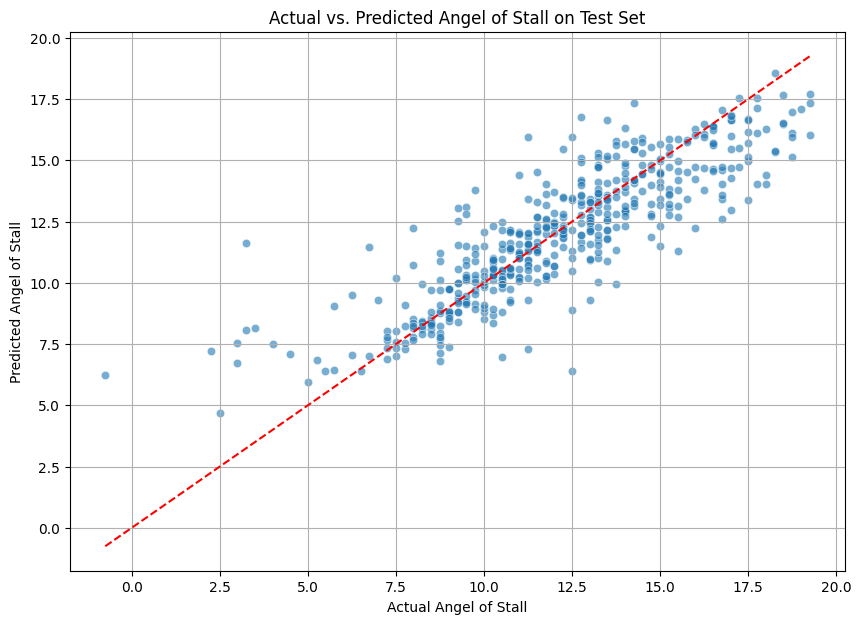

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make predictions on the dedicated 10% test set
y_pred_test = cat_model.predict(X_test)

# 2. Calculate the R-squared score
r2_test = r2_score(y_test, y_pred_test)

# 3. Calculate Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_pred_test)

# 4. Calculate Mean Squared Error (MSE)
mse_test = mean_squared_error(y_test, y_pred_test)

# 5. Calculate Root Mean Squared Error (RMSE)
rmse_test = np.sqrt(mse_test)

# 6. Print the calculated metrics
print(f"Evaluation on Test Set:")
print(f"R-squared score: {r2_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")

# 7. Generate a scatter plot for actual vs. predicted values
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)

# 8. Add a red dashed line for perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# 9. Label the axes
plt.xlabel("Actual Angel of Stall")
plt.ylabel("Predicted Angel of Stall")

# 10. Add a title to the plot
plt.title("Actual vs. Predicted Angel of Stall on Test Set")

plt.grid(True)
# 11. Display the plot
plt.show()